In [3]:
import json 
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
from collections import defaultdict

def get_prediction(prob_dict_list):
    predicted_toks_and_probs = []
    for timestep, prob_dict in enumerate(prob_dict_list): 
        toks, probs = zip(*prob_dict.items())
        # print(prob_dict['SourceCopy'])
        # best_prob_idx = np.argmax(probs)
        top_k_idxs = np.argpartition(probs, -4)[-4:]
        # best_prob, best_tok = probs[top_k_idxs[0]], toks[top_k_idxs[0]]
        top_probs, top_toks = [probs[x] for x in top_k_idxs], [toks[x] for x in top_k_idxs]
        best_prob_idx = np.argmax(top_probs)
        best_tok, best_prob = top_toks[best_prob_idx], top_probs[best_prob_idx]
        predicted_toks_and_probs.append((best_tok, best_prob, top_probs, top_toks))
    return predicted_toks_and_probs

def check_tokens(pred_tok, tgt_tok, prev_tgts):
    if "SourceCopy" not in pred_tok and "TargetCopy" not in pred_tok:
        return pred_tok == tgt_tok
    elif "SourceCopy" in pred_tok:
        return pred_tok.split("_")[1] == tgt_tok
    else:
        try:
            tok_idx = int(pred_tok.split("_")[1])-1
            return prev_tgts[tok_idx] == tgt_tok
        except IndexError:
            print(len(prev_tgts))
            print(pred_tok)
            print(prev_tgts)
            raise AssertionError
    

def read_json(path): 
    print(f"opening data")
    with open(path) as f1:
        data = json.load(f1)
    print(f"got data")
    return data

def get_probs(data):
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    mistakes, corrects = [], []

    for instance_idx, instance in tqdm(enumerate(data)): 
        instance = instance
        left_context = [x[0] for x in instance['left_context']][1:]
        target_toks = left_context + ["@end@"]
        probs = instance['prob_dist']
        predicted_toks = get_prediction(probs)

        source_tokens = " ".join([x[0] for x in instance['source_tokens']])
        for i in range(len(left_context)):
            input_token = left_context[i]
            output_token = predicted_toks[i][0]
            output_prob = predicted_toks[i][1]
            top_k_tokens = predicted_toks[i][2]
            top_k_probs = predicted_toks[i][3]
            target_token = target_toks[i]
            tokens_are_equal = check_tokens(output_token, target_token, left_context[:i])
            if not tokens_are_equal:
                mistake = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                mistakes.append(mistake)
            else:
                correct = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                corrects.append(correct)

    return mistakes, corrects


def convert_to_metric_format(path, out_path):
    data = read_json(path)

    to_ret = []
    for instance_idx, instance in tqdm(enumerate(data)): 

        input_str = " ".join([x[0] for x in instance['source_tokens']])
        probs = instance['prob_dist']
        left_context = [x[0] for x in instance['left_context']][1:]
        target_toks = left_context + ["@end@"]
        predicted_toks = get_prediction(probs)
        top_logits = [predicted_toks[i][2] for i in range(len(predicted_toks))]
        top_logit_idxs = [predicted_toks[i][3] for i in range(len(predicted_toks))]
        labels = [target_toks[i] for i in range(len(predicted_toks))]
        to_ret.append({"top_logits": top_logits,
                    "top_logit_idxs": top_logit_idxs,
                    "labels": labels,
                    "input_str": input_str} )


    with open(out_path, "w") as f1:
        for line in to_ret:
            f1.write(json.dumps(line) + "\n")


In [6]:
# data = read_json("/brtx/604-nvme2/estengel/miso_models/tune_roberta//translate_output/dev_valid_losses.json")
data = read_json("/brtx/603-nvme1/estengel/calflow_calibration/tune_roberta_number_tokenize/translate_output/dev_valid_losses.json")
# data = read_json("/brtx/603-nvme1//estengel/calflow_calibration/tree_dst/tune_roberta/translate_output/valid_losses.json")
# data = read_json("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data//translate_output/test_all_losses.json")

# convert_to_metric_format("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data//translate_output/test_all_losses.json", 
                        # "/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data//translate_output/test_all.logits")

# convert_to_metric_format("/brtx/603-nvme1/estengel/calflow_calibration/tune_roberta_number_tokenize/translate_output/dev_valid_losses.json",
#                         "/brtx/603-nvme1/estengel/calflow_calibration/tune_roberta_number_tokenize/translate_output/dev_valid.logits")

opening data
got data


In [7]:
mistakes, corrects = get_probs(data)

6882it [00:23, 292.50it/s]


In [8]:
from collections import Counter
print(len(mistakes))
print(len(corrects))

mistake_examples = len(set([x['instance_idx'] for x in mistakes])) 
correct_examples = len(set([x['instance_idx'] for x in corrects]))

mistake_idxs = [x['instance_idx'] for x in mistakes]
mistake_counter = Counter(mistake_idxs)
mistake_only_once = [x for x in mistake_counter if mistake_counter[x] == 1]
print(f"{len(mistake_only_once)} of {mistake_examples} ({len(mistake_only_once)/mistake_examples*100:.2f}%) examples have one mistake only")
print(f"number of unique failures: {len(mistakes)}")
print("number of failure examples: " +  str(mistake_examples))
print("number of correct examples: " +  str(correct_examples)) 

print(f"accuracy: {correct_examples/(correct_examples+mistake_examples)}")

print(f"mistakes per mistake example: {len(mistakes)/mistake_examples}")


1814
89909
962 of 1277 (75.33%) examples have one mistake only
number of unique failures: 1814
number of failure examples: 1277
number of correct examples: 6882
accuracy: 0.8434857212893737
mistakes per mistake example: 1.4205168363351606


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 



In [10]:
mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]


print(np.mean(mistake_probs))
print(np.mean(correct_probs))

# prob_df = pd.DataFrame(columns=['prob', 'correct'])
prob_df_data = []
for prob in mistake_probs:
    prob_df_data.append({'prob': prob, 'correct': False}) 
for prob in correct_probs:
    prob_df_data.append({'prob': prob, 'correct': True}) 


prob_df = pd.DataFrame(prob_df_data)





0.8100887148783777
0.9931453792587237


In [15]:
import scipy 
from collections import Counter

print(len(prob_df))
print(prob_df['correct'].sum())

values, bin_edges, bin_number = scipy.stats.binned_statistic(prob_df['prob'], 
                                                             prob_df['correct'], 
                                                             statistic='mean', 
                                                             bins=20)
bin_lookup = Counter(bin_number)

91723
89909


[0.16666667 0.         0.1        0.34615385 0.26086957 0.41304348
 0.40384615 0.48113208 0.47305389 0.51807229 0.53977273 0.56081081
 0.62087912 0.65671642 0.67901235 0.7003367  0.75609756 0.78144654
 0.8399326  0.9930653 ]
[0.18927671 0.22981277 0.27034882 0.31088488 0.35142094 0.391957
 0.43249305 0.47302911 0.51356517 0.55410122 0.59463728 0.63517334
 0.6757094  0.71624545 0.75678151 0.79731757 0.83785363 0.87838968
 0.91892574 0.9594618  0.99999785]
   prob_model  prob_correct  count  log_count
0    0.189277      0.166667    NaN   1.791759
1    0.229813      0.000000    NaN   1.945910
2    0.270349      0.100000    NaN   2.302585
3    0.310885      0.346154    NaN   3.258097
4    0.351421      0.260870    NaN   3.135494


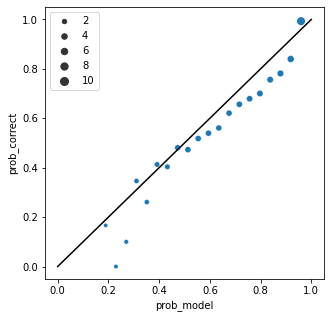

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

df_to_plot = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
print(values)
print(bin_edges)
for i, (val, edge, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
    df_to_plot = df_to_plot.append({"prob_model": edge, 
                                    "prob_correct": val, 
                                    "log_count": np.log(bin_lookup[i+1])}, 
                                    ignore_index=True)


sns.scatterplot(data=df_to_plot, x = "prob_model", y="prob_correct", size="log_count", ax=ax, legend='brief')
xs_line = np.linspace(0,1,2)
ys_line = xs_line
sns.lineplot(x = xs_line, y=ys_line, ax=ax, color='black')

print(df_to_plot.head())

In [9]:
np.random.seed(12)
# inspect mistakes 
# sample 10 from across the range of mistakes
n_bins = 20
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i]
    if len(bin_mistakes) == 0:
        print(i)
        print(bin_number[0:10])

    mistake = np.random.choice(bin_mistakes, size=1)[0]
    print(f"Source: {mistake['source_tokens']}")
    print(f"Left context: {mistake['left_context']}")
    print(f"TARGET: {mistake['target_toks']}")
    print(f"PRED TOK {mistake['output_token']}")
    print(f"TOP PREDS: {mistake['top_k_tokens']}")
    print(f"TOP PROBS: {mistake['top_k_probs']}")
    print(f"TRUE TARGET: {mistake['target_token']}")
    print("")


Source: __User How expensive is Montana Carl 's in Glendive ? __Agent I found 2 different places matching that description . Can you be more specific ? __User Which one charges higher prices ?
Left context: ['@ROOT@', 'Yield', 'minBy', 'Path.apply', 'String']
TARGET: ['@ROOT@', 'Yield', 'minBy', 'Path.apply', 'String', 'price', 'PlaceSearchResponse.results', 'Execute', 'refer', 'extensionConstraint', 'EmptyStructConstraint', 'PlaceSearchResponse', '@end@']
PRED TOK True
TOP PREDS: [0.0539025142788887, 0.08463993668556213, 0.09757255762815475, 0.1373414844274521]
TOP PROBS: ['showAs', 'PlaceSearchResponse.results', 'attendees', 'True']
TRUE TARGET: price

Source: __User Do I have a meeting this afternoon ? __Agent Yes , I found 2 events this afternoon . The first is " Team meeting " today from 1 : 00 to 1 : 30 PM . __User Will it be in the main office ?
Left context: ['@ROOT@', 'Yield']
TARGET: ['@ROOT@', 'Yield', '>', 'Long', '0', 'size', 'QueryEventResponse.results', 'FindEventWrapper

In [10]:
import scipy
from scipy import stats
np.random.seed(12)
# lets look at inputs for 100 mistakes 
n_bins = 100
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i and mistake_counter[x['instance_idx']] == 1]
    if len(bin_mistakes) == 0:
        continue
    mistake = np.random.choice(bin_mistakes, size=1)[0]
    utt = mistake['source_tokens'].split("__User")[-1]
    print(f"{utt}, {mistake['output_token']}, {mistake['target_token']}, {mistake['output_prob']:.3f}")

 Create an event for 3 k run on Saturday from 8 am to 12 pm, 5k, 3k, 0.189
 Will it be in the main office ?, ==, >, 0.219
 I have a hike with Polly at 0330, 45, 30, 0.262
 Should I wear short sleeves today in Lake City , FL ?, IsHighUV, WeatherQueryApi, 0.273
 Thank you but I need it for NEXT Friday the 18 th from 8 pm-11 : 30 pm, NextDOW, nextDayOfMonth, 0.277
 mark tomorrow as busy from 6 am-6 pm, 10, 6, 0.300
 Before or after the duck ?, Yield, PleasantryAnythingElseCombined, 0.316
 We the People of the United States , in Order to form a more perfect Union , establish Justice , insure domestic Tranquility , provide for the common defence , promote the general Welfare , and secure the Blessings of Liberty to ourselves and our Posterity , do ordain and establish this Constitution for the United States of America ., FenceGibberish, PleasantryAnythingElseCombined, 0.325
 Do I have a 3 hour block of time for tuesday ?, RecipientAvailability, CreateCommitEventWrapper, 0.338
 Make an after

(0.995, 1.0)

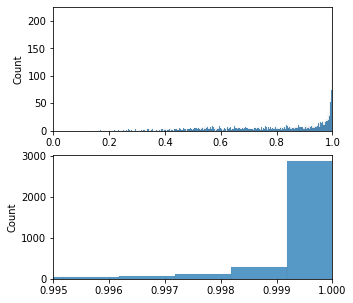

In [11]:
# What percentage of mistakes are low probability? 
# What percentage of correct are high probability? 

mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]
correct_probs = np.random.choice(correct_probs, size = len(mistake_probs), replace=False)
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=False, sharey=False)
sns.histplot(mistake_probs, ax=ax[0], binwidth=0.001)
sns.histplot(correct_probs, ax=ax[1], binwidth=0.001)
ax[0].set_xlim(0.0, 1.0)
ax[1].set_xlim(0.995, 1.0)



In [12]:
# what's the optimal threshold? 

def compute_f1(df, thresh, downsample=True, min_sample_size=1000):
    pred_mistakes = df[df['prob'] < thresh]
    pred_corrects = df[df['prob'] >= thresh]
    if len(pred_mistakes) < min_sample_size or len(pred_corrects) < min_sample_size:
        return [0, 0, 0, 0]
    if downsample:
        min_len = min(len(pred_mistakes), len(pred_corrects))
        pred_mistakes = pred_mistakes.sample(n=min_len, replace=False)
        pred_corrects = pred_corrects.sample(n=min_len, replace=False)


    false_negatives = len(pred_mistakes[pred_mistakes['correct'] == True])
    false_positives = len(pred_corrects[pred_corrects['correct'] == False])
    true_positives = len(pred_corrects[pred_corrects['correct'] == True])
    true_negatives = len(pred_mistakes[pred_mistakes['correct'] == False])
    try:
        precision = true_positives/(true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_positives/(true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0
    try:
        f1 = 2*precision*recall/(precision + recall)
    except ZeroDivisionError:
        f1 = 0


    accuracy = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    return [f1, precision, recall, accuracy]

threshes = np.arange(0.00, 1.0, 0.01)
f1s = [[thresh] + compute_f1(prob_df, thresh) for thresh in threshes]

# why is this so low, seems like 0.49 misses most of the true negatives
# F1 score doesn't take true negatives into account; since there are a lot more correct than mistake, 
# maybe classifying everything as correct isn't that bad
# we get 0.0.98 precision, 1.0 recall by setting threshold to 0.0; that's not good 
best_thresh_f1, *best_f1 = max(f1s, key=lambda x: x[1])
best_thresh_acc, *best_acc = max(f1s, key=lambda x: x[-1])
print("f1", best_thresh_f1, best_f1)
print(f"accuracy", best_thresh_acc, best_acc)


# so anything less than 0.995 confidence can safely be said to be a mistake, with 0.94 F1 (pretty good), super high precision, lower recall 

f1 0.6 [0.8107142857142857, 0.9826839826839827, 0.6899696048632219, 0.7705627705627706]
accuracy 0.58 [0.8105691056910569, 0.9803343166175025, 0.6909216909216909, 0.7708947885939036]
